# Instructions
You will submit an HTML document to Canvas as your final version.

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.

The Data
This week, we consider a dataset generated from text data.

The original dataset can be found here: https://www.kaggle.com/datasets/kingburrito666/cannabis-strains. It consists of user reviews of different strains of cannabis. Users rated their experience with the cannabis strain on a scale of 1 to 5. They also selected words from a long list to describe the Effects and the Flavor of the cannabis.

In the dataset linked above, each row is one strain of cannabis. The average rating of all testers is reported, as well as the most commonly used words for the effect and flavor.

Some data cleaning has been performed for you: The Effect and Flavor columns have been converted to dummy variables indicating if the # Particular word was used for the # Particular strain.

This cleaned data can be found at: https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv

Our goal will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.

IMPORTANT: In this assignment, you do not need to consider different feature sets. Normally, this would be a good thing to try - but for this homework, simply include all the predictors for every model.


In [44]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import balanced_accuracy_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, classification_report

import plotnine as p9

In [45]:
url = 'https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv?dl=1'
df = pd.read_csv(url)

In [46]:
df.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df.describe()

,Rating,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
count,2351.000000,2321.000000,2320.000000,2313.000000,2331.000000,2318.000000,2306.000000,2326.000000,2330.000000,2318.000000,...,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000
mean,4.310634,0.321844,0.278448,0.149589,0.701416,0.744607,0.086297,0.804385,0.646781,0.206644,...,0.012148,0.017787,0.014751,0.014751,0.008243,0.018221,0.003471,0.006941,0.000868,0.001302
std,0.836394,0.467284,0.448332,0.356745,0.457735,0.436176,0.280862,0.396759,0.478073,0.404985,...,0.109568,0.132207,0.120579,0.120579,0.090435,0.133780,0.058823,0.083044,0.029450,0.036061
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.400000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.700000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
df['Type'] = df['Type'].astype(str).str.strip().str.lower()

In [49]:
exclude_cols = ['Strain', 'Type', 'Rating', 'Effects', 'Flavor']
predictors = [c for c in df.columns if c not in exclude_cols]

In [50]:
print("Rows, Columns:", df.shape)
print("Classes:", df['Type'].value_counts().to_dict())

Rows, Columns: (2351, 69)
Classes: {'hybrid': 1212, 'indica': 699, 'sativa': 440}


# Part One: Binary Classification
Create a dataset that is limited only to the Sativa and Indica type cannabis strains.

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

Report the (cross-validated!) metric.

Fit the final model.

Output a confusion matrix.

In [51]:
df_binary = df[df['Type'].isin(['sativa', 'indica'])]

In [52]:
X_binary = df_binary[predictors]
y_binary = df_binary['Type']

In [53]:
print("Total NaNs in X_binary:", int(X_binary.isna().sum().sum()))

Total NaNs in X_binary: 1272


In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [55]:
SCORER = 'f1_macro' 

## Q1: LDA


In [56]:
lda_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])


In [57]:
lda_cv = cross_val_score(lda_pipe, X_binary, y_binary, cv=cv, scoring=SCORER).mean()
print(f"[LDA] Cross-Validated Macro F1: {lda_cv}")

[LDA] Cross-Validated Macro F1: 0.81932618237756


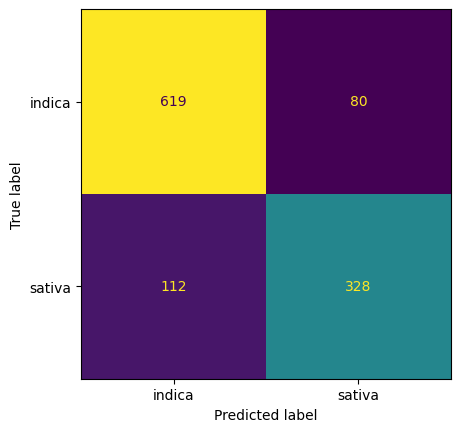

In [58]:
lda_y_pred = cross_val_predict(lda_pipe, X_binary, y_binary, cv=cv)
lda_cm = confusion_matrix(y_binary, lda_y_pred, labels=['indica','sativa'])
ConfusionMatrixDisplay(lda_cm, display_labels=['indica','sativa']).plot(colorbar=False)

## Q2: QDA


In [59]:
qda_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('qda', QuadraticDiscriminantAnalysis(reg_param=0.0))
])

In [60]:
qda_grid = { 'qda__reg_param': np.linspace(0, 0.4, 9) }
qda_gs = GridSearchCV(qda_pipe, qda_grid, cv=cv, scoring=SCORER, n_jobs=-1)
qda_gs.fit(X_binary, y_binary)

,estimator,Pipeline(step...tAnalysis())])
,param_grid,"{'qda__reg_param': array([0. , ..., 0.35, 0.4 ])}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [61]:
print("Best QDA params:", qda_gs.best_params_)
print(f"QDA Cross-Validated Macro F1: {qda_gs.best_score_}")

Best QDA params: {'qda__reg_param': np.float64(0.2)}
QDA Cross-Validated Macro F1: 0.8351083690471309


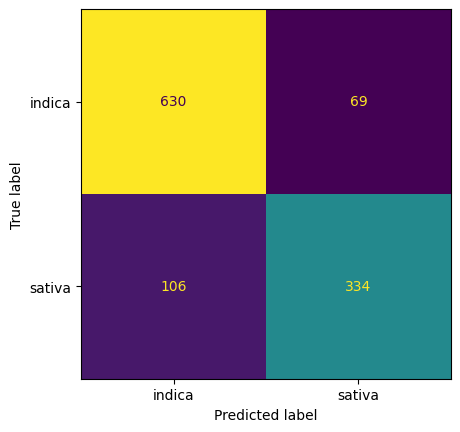

In [62]:
qda_best = qda_gs.best_estimator_
qda_y_pred = cross_val_predict(qda_best, X_binary, y_binary, cv=cv)
qda_cm = confusion_matrix(y_binary, qda_y_pred, labels=['indica','sativa'])
ConfusionMatrixDisplay(qda_cm, display_labels=['indica','sativa']).plot(colorbar=False)

## Q3: SVC


In [63]:
svc_rbf_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False)),
    ('svc', SVC(kernel='rbf'))
])

In [64]:
svc_param_grid = {
    'svc__C': [0.1, 1, 3, 10],
    'svc__gamma': ['scale', 0.01, 0.03, 0.1]
}

In [65]:
svc_gs = GridSearchCV(svc_rbf_pipe, svc_param_grid, cv=cv, scoring=SCORER, n_jobs=-1)
svc_gs.fit(X_binary, y_binary)

,estimator,"Pipeline(step...svc', SVC())])"
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': ['scale', 0.01, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [66]:
print("[SVC (RBF)] Best params:", svc_gs.best_params_)
print(f"[SVC (RBF)] Cross-Validated Macro F1: {svc_gs.best_score_}")


[SVC (RBF)] Best params: {'svc__C': 3, 'svc__gamma': 0.01}
[SVC (RBF)] Cross-Validated Macro F1: 0.8233630881910639


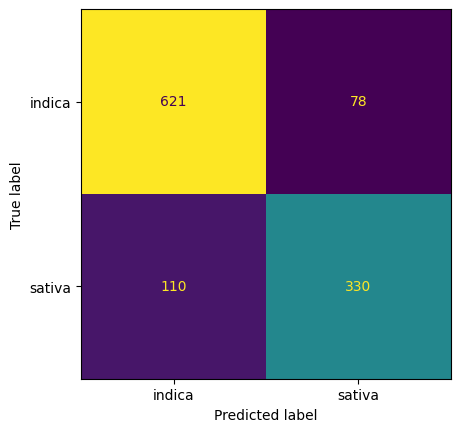

In [67]:
svc_best = svc_gs.best_estimator_
svc_y_pred = cross_val_predict(svc_best, X_binary, y_binary, cv=cv)
svc_cm = confusion_matrix(y_binary, svc_y_pred, labels=['indica','sativa'])
ConfusionMatrixDisplay(svc_cm, display_labels=['indica','sativa']).plot(colorbar=False)

## Q4: SVM

In [68]:
svm_poly_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False)),
    ('svm', SVC(kernel='poly'))
])

In [69]:
svm_poly_grid = {
    'svm__C': [0.1, 1, 3, 10],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0.0, 0.5, 1.0]
}

In [70]:
svm_poly_gs = GridSearchCV(svm_poly_pipe, svm_poly_grid, cv=cv, scoring=SCORER, n_jobs=-1)
svm_poly_gs.fit(X_binary, y_binary)

,estimator,Pipeline(step...nel='poly'))])
,param_grid,"{'svm__C': [0.1, 1, ...], 'svm__coef0': [0.0, 0.5, ...], 'svm__degree': [2, 3, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [71]:
print("[SVM (poly)] Best params:", svm_poly_gs.best_params_)
print(f"[SVM (poly)] Cross-Validated Macro F1: {svm_poly_gs.best_score_}")

[SVM (poly)] Best params: {'svm__C': 3, 'svm__coef0': 0.5, 'svm__degree': 2}
[SVM (poly)] Cross-Validated Macro F1: 0.8374573032577344


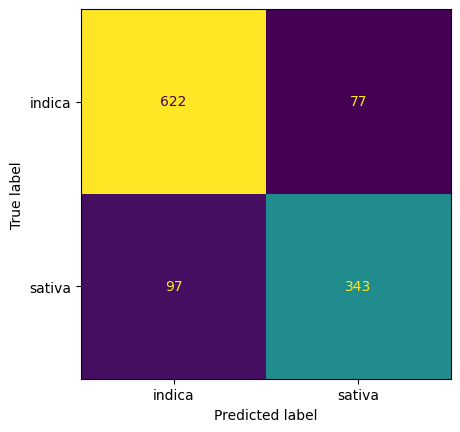

In [72]:
svm_poly_best = svm_poly_gs.best_estimator_
svm_poly_y_pred = cross_val_predict(svm_poly_best, X_binary, y_binary, cv=cv)
svm_poly_cm = confusion_matrix(y_binary, svm_poly_y_pred, labels=['indica','sativa'])
ConfusionMatrixDisplay(svm_poly_cm, display_labels=['indica','sativa']).plot(colorbar=False)

LDA, QDA, RBF SVC, poly SVM do really well on the simple “Indica vs Sativa” task – the macro F1 scores are all around 0.82–0.84.

The differences between models are pretty small. QDA and the polynomial SVM are usually just a tiny bit better, but nothing dramatic.

The confusion matrices show that the models are making relatively few mistakes and they aren’t heavily biased toward one of the two classes.

# Part Two: Natural Multiclass
Now use the full dataset, including the Hybrid strains.


In [73]:
X_full = df[predictors]
y_full = df['Type']


### Q1
Fit a decision tree, plot the final fit, and interpret the results.

In [74]:
tree_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('tree', DecisionTreeClassifier(random_state=42))
])

In [75]:
tree_grid = {
    'tree__max_depth': [3, 4, 5, 6, None],
    'tree__min_samples_split': [2, 5, 10, 20],
    'tree__min_samples_leaf': [1, 2, 5, 10]
}

In [76]:
tree_gs = GridSearchCV(tree_pipe, tree_grid, cv=cv, scoring=SCORER, n_jobs=-1)
tree_gs.fit(X_full, y_full)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'tree__max_depth': [3, 4, ...], 'tree__min_samples_leaf': [1, 2, ...], 'tree__min_samples_split': [2, 5, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,missing_values,nan


In [77]:
print("[Decision Tree] Best params:", tree_gs.best_params_)
print(f"[Decision Tree] Cross-Validated Macro F1: {tree_gs.best_score_}")


[Decision Tree] Best params: {'tree__max_depth': 3, 'tree__min_samples_leaf': 5, 'tree__min_samples_split': 2}
[Decision Tree] Cross-Validated Macro F1: 0.5862076053271723


In [ ]:
imputer = SimpleImputer(strategy='most_frequent').fit(X_full)
X_imp = pd.DataFrame(imputer.transform(X_full), columns=predictors)
final_tree = DecisionTreeClassifier({k.replace("tree__", ""): v for k, v in tree_gs.best_params_.items()}, random_state=42)
final_tree.fit(X_imp, y_full)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [79]:
importances = pd.Series(final_tree.feature_importances_, index=predictors).sort_values(ascending=False)
print("Top 15 feature importances:\n", importances.head(15))


Top 15 feature importances:
 Sleepy       0.700771
Energetic    0.180264
Relaxed      0.050795
Citrus       0.025170
Uplifted     0.018517
Diesel       0.014384
Woody        0.010098
Euphoric     0.000000
Happy        0.000000
Hungry       0.000000
Giggly       0.000000
Talkative    0.000000
Focused      0.000000
Tingly       0.000000
Aroused      0.000000
dtype: float64


- Sleepy is by far the most important feature.
- Next come Energetic and Relaxed.
- Then a few smaller ones like Citrus, Uplifted, Diesel, Woody, etc.

The tree is basically asking:
“Does this strain make you sleepy or wired?”  
and then using that to decide whether it’s closer to Indica, Sativa, or in the middle as a Hybrid

### Q2
Repeat the analyses from # Part One for LDA, QDA, and KNN.



[Multiclass LDA] CV Macro F1: 0.5863503861342954


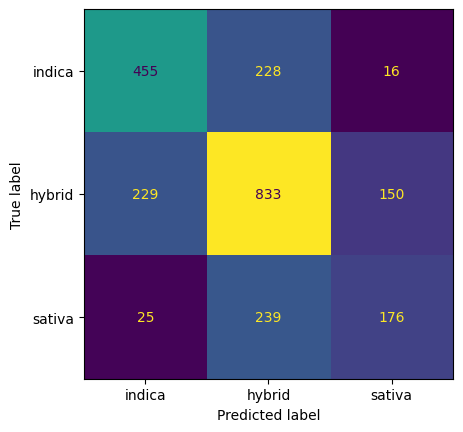

In [80]:
lda_mc = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False)),
    ('lda', LinearDiscriminantAnalysis())
])

lda_mc_cv = cross_val_score(lda_mc, X_full, y_full, cv=cv, scoring=SCORER).mean()
print(f"[Multiclass LDA] CV Macro F1: {lda_mc_cv}")
lda_mc_pred = cross_val_predict(lda_mc, X_full, y_full, cv=cv)
ConfusionMatrixDisplay(confusion_matrix(y_full, lda_mc_pred, labels=['indica','hybrid','sativa']),
                       display_labels=['indica','hybrid','sativa']).plot(colorbar=False)

[Multiclass QDA] Best params: {'qda__reg_param': np.float64(0.15000000000000002)}
[Multiclass QDA] CV Macro F1: 0.585355065155993


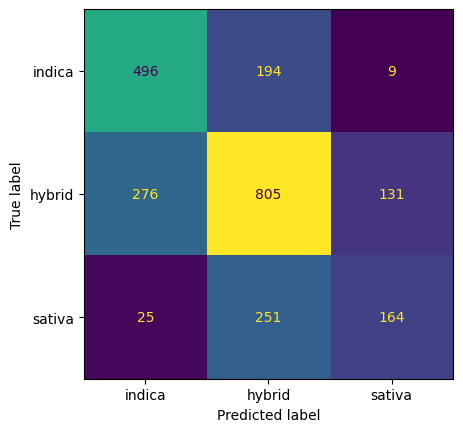

In [81]:
qda_mc = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('qda', QuadraticDiscriminantAnalysis())
])

qda_mc_grid = {'qda__reg_param': np.linspace(0, 0.4, 9)}
qda_mc_gs = GridSearchCV(qda_mc, qda_mc_grid, cv=cv, scoring=SCORER, n_jobs=-1)
qda_mc_gs.fit(X_full, y_full)
print("[Multiclass QDA] Best params:", qda_mc_gs.best_params_)
print(f"[Multiclass QDA] CV Macro F1: {qda_mc_gs.best_score_}")
qda_mc_best = qda_mc_gs.best_estimator_
qda_mc_pred = cross_val_predict(qda_mc_best, X_full, y_full, cv=cv)
ConfusionMatrixDisplay(confusion_matrix(y_full, qda_mc_pred, labels=['indica','hybrid','sativa']),
                       display_labels=['indica','hybrid','sativa']).plot(colorbar=False)

[Multiclass KNN] Best params: {'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
[Multiclass KNN] CV Macro F1: 0.5072088260586084


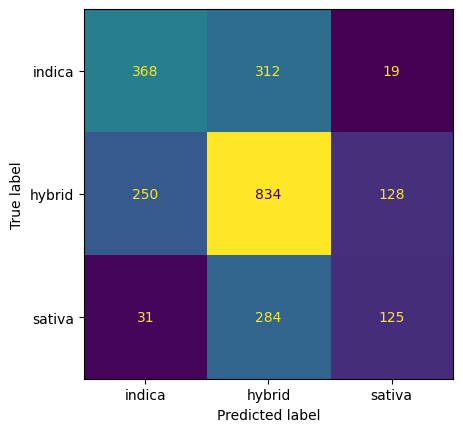

In [82]:
knn_mc = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

knn_mc_grid = {
    'knn__n_neighbors': [3, 5, 7, 11, 15, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # Manhattan vs Euclidean
}

knn_mc_gs = GridSearchCV(knn_mc, knn_mc_grid, cv=cv, scoring=SCORER, n_jobs=-1)
knn_mc_gs.fit(X_full, y_full)
print("[Multiclass KNN] Best params:", knn_mc_gs.best_params_)
print(f"[Multiclass KNN] CV Macro F1: {knn_mc_gs.best_score_}")
knn_mc_best = knn_mc_gs.best_estimator_
knn_mc_pred = cross_val_predict(knn_mc_best, X_full, y_full, cv=cv)
ConfusionMatrixDisplay(confusion_matrix(y_full, knn_mc_pred, labels=['indica','hybrid','sativa']),
                       display_labels=['indica','hybrid','sativa']).plot(colorbar=False)

### Q3
Were your metrics better or worse than in # Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

When we move from 2 classes (Indica vs Sativa) to 3 classes (Indica, Hybrid, Sativa), the scores drop:

- Binary models: macro F1 ≈ 0.82–0.84.
- Multiclass models:
  - LDA: ≈ 0.59
  - QDA: ≈ 0.59
  - KNN: ≈ 0.51

The new Hybrid class is basically a mix of Indica and Sativa traits.

Many Hybrids look “kind of Indica” or “kind of Sativa” based on their effects and flavor, so the boundaries between classes get blurry.

With three classes, there are simply more ways to be wrong, and macro F1 punishes each class equally.


From the confusion matrices:

- Indica and Sativa are still relatively distinct.
- Hybrid is the “confused middle child”:
  - Chill, sleepy Hybrids often get predicted as Indica.
  - Energetic, uplifting Hybrids sometimes get predicted as Sativa.

That behavior actually makes sense: Hybrids are meant to be in-between, and the models are reflecting that.

# Part Three: Multiclass from Binary
Consider two models designed for binary classification: SVC and Logistic Regression.

In [83]:
def ovr_task_metrics(pipe, X, y, positive_label):
    y_bin = (y == positive_label).astype(int)
    y_pred = cross_val_predict(pipe, X, y_bin, cv=cv)
    f1 = f1_score(y_bin, y_pred)
    bal = balanced_accuracy_score(y_bin, y_pred)
    return f1, bal

In [84]:
labels = ['indica','sativa','hybrid']


### Q1
Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:

Indica vs. Not Indica

Sativa vs. Not Sativa

Hybrid vs. Not Hybrid



In [85]:
base_impute_scale = [
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler(with_mean=False))
]

In [86]:
svc_linear_ovr = Pipeline(base_impute_scale + [
    ('clf', OneVsRestClassifier(LinearSVC(random_state=42, max_iter=2000)))
])

In [87]:
logreg_ovr = Pipeline(base_impute_scale + [
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=2000, solver='liblinear')))
])

In [88]:

print("=== OvR: Linear SVC ===")
for lab in labels:
    f1v, balv = ovr_task_metrics(svc_linear_ovr, X_full, y_full, lab)
    print(f"{lab} vs not-{lab}: F1={f1v}, BalAcc={balv}")


=== OvR: Linear SVC ===
indica vs not-indica: F1=0.6358897989575577, BalAcc=0.7397583715234839
sativa vs not-sativa: F1=0.36251920122887865, BalAcc=0.6097580990438134
hybrid vs not-hybrid: F1=0.6625, BalAcc=0.630344202111168


In [89]:
print("\n=== OvR: Logistic Regression ===")
for lab in labels:
    f1v, balv = ovr_task_metrics(logreg_ovr, X_full, y_full, lab)
    print(f"{lab} vs not-{lab}: F1={f1v}, BalAcc={balv}")



=== OvR: Logistic Regression ===
indica vs not-indica: F1=0.6369137670196672, BalAcc=0.7400064776037716
sativa vs not-sativa: F1=0.39067055393586003, BalAcc=0.6229686979686979
hybrid vs not-hybrid: F1=0.6603921568627451, BalAcc=0.6296248808375131


### Q2
Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?



From the one-vs-rest results:

- The best tasks (highest F1) are:
  - Hybrid vs not-Hybrid for both Linear SVC and Logistic Regression     (F1 around 0.66).
- The worst tasks (lowest F1) are:
  - Sativa vs not-Sativa for both models (F1 only in the high 0.3s).

In OvR form:

- Hybrid is easiest to flag,
- Sativa is hardest.


### Q3
Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

Indica vs. Sativa

Indica vs. Hybrid

Hybrid vs. Sativa



In [90]:
pairs = [('indica','sativa'), ('indica','hybrid'), ('hybrid','sativa')]

In [91]:
def subset_pair(X, y, a, b):
    mask = y.isin([a, b])
    return X[mask], y[mask]

In [92]:
def fit_pair_and_report(pipe, X, y, a, b, title):
    Xp, yp = subset_pair(X, y, a, b)
    ypred = cross_val_predict(pipe, Xp, yp, cv=cv)
    f1m = f1_score(yp, ypred, average='macro')
    cm = confusion_matrix(yp, ypred, labels=[a, b])
    print(f"[{title}] {a} vs {b} — Macro F1: {f1m:.4f}")
    ConfusionMatrixDisplay(cm, display_labels=[a, b]).plot(colorbar=False)

In [93]:
svc_linear_ovo = Pipeline(base_impute_scale + [
    ('clf', OneVsOneClassifier(LinearSVC(random_state=42, max_iter=2000)))
])


In [94]:
logreg_ovo = Pipeline(base_impute_scale + [
    ('clf', OneVsOneClassifier(LogisticRegression(max_iter=2000, solver='liblinear')))
])

=== OvO: Linear SVC ===
[OvO Linear SVC] indica vs sativa — Macro F1: 0.8206
[OvO Linear SVC] indica vs hybrid — Macro F1: 0.7364
[OvO Linear SVC] hybrid vs sativa — Macro F1: 0.6193


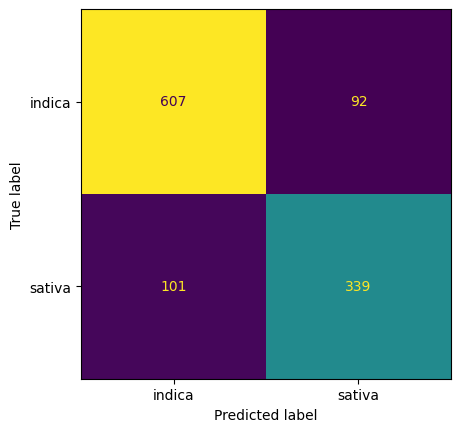

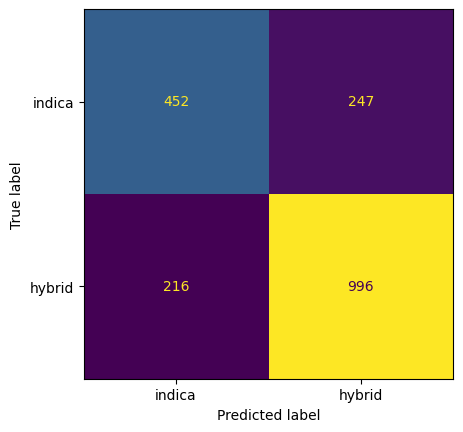

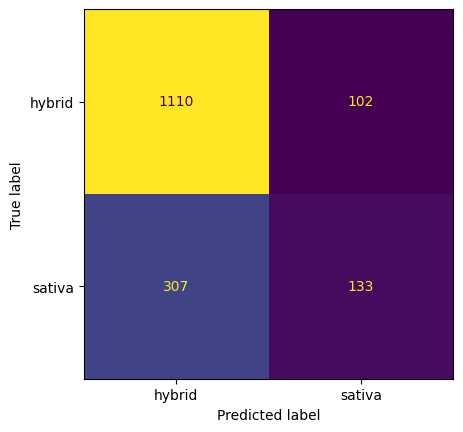

In [95]:
print("=== OvO: Linear SVC ===")
for a, b in pairs:
    fit_pair_and_report(svc_linear_ovo, X_full, y_full, a, b, "OvO Linear SVC")


=== OvO: Logistic Regression ===
[OvO Logistic Regression] indica vs sativa — Macro F1: 0.8216
[OvO Logistic Regression] indica vs hybrid — Macro F1: 0.7307
[OvO Logistic Regression] hybrid vs sativa — Macro F1: 0.6331


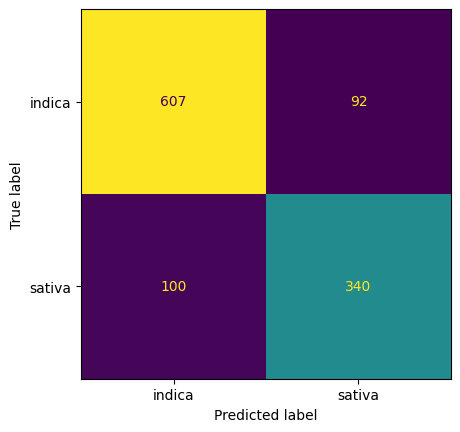

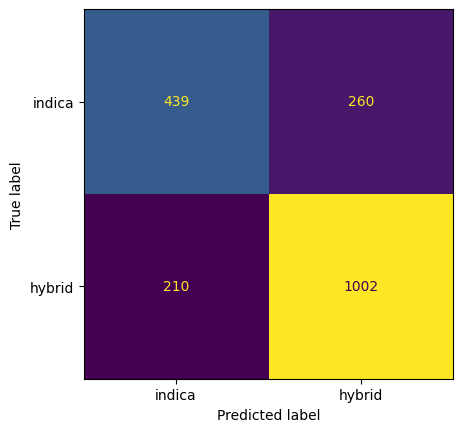

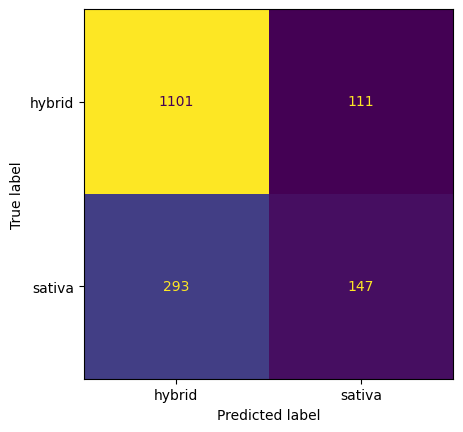

In [96]:
print("=== OvO: Logistic Regression ===")
for a, b in pairs:
    fit_pair_and_report(logreg_ovo, X_full, y_full, a, b, "OvO Logistic Regression")


### Q4
Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?



For the one-vs-one comparisons, the macro F1 scores look roughly like this:

- Indica vs Sativa: ~0.82 (best for both models)
- Indica vs Hybrid: ~0.73–0.74
- Hybrid vs Sativa: ~0.62–0.63 (worst for both models)

Hybrids overlap with both pure types, but they especially bump into Sativas on the “energetic” side.

- The model is best at separating the two extremes (Indica vs Sativa)
- Worst at separating a mixed middle class (Hybrid) from the more similar pure type (Sativa)

### Q5
Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

What about for SVC?

- LogisticRegression would automatically use a One-vs-Rest (OvR) approach.
  - That means it would train one model per class

- SVC does the opposite: it automatically uses One-vs-One (OvO) for multiclass.
   - This means it trains a separate classifier for every pair of classes, then combines their votes to make a final decision.